# 物流数据分析项目

In [46]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from pyecharts.charts import Bar,Line
from pyecharts.globals import ThemeType
from pyecharts import options as opts
from pyecharts.globals import JsCode
from pyecharts.globals import CurrentConfig  # 加载全局配置
CurrentConfig.ONLINE_HOST = "http://127.0.0.1:8000/assets/"  # 设定静态资源地址
from pyecharts.datasets import register_url  # 部分地图文件注册
# 注册本地服务器的地图数据源
register_url("http://127.0.0.1:8000/") 
print('Python version:', sys.version)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Matplotlib version:', matplotlib.__version__)

Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]

Pandas version: 2.2.2

Numpy version: 1.26.4

Matplotlib version: 3.8.4

## 案例目标

通过对湖南,湖北两个省份的物流数据进行分析,对比两个省份物业业务的情况,主要是同质化分析和差异化分析

In [85]:
data_s = pd.read_excel('./data/湖南.xls',index_col=0)
data_n = pd.read_excel('./data/湖北.xls')

In [86]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Columns: 246 entries, 平台 to 客户帐号流水号
dtypes: datetime64[ns](14), float64(130), int64(23), object(79)
memory usage: 20.0+ MB


In [87]:
data_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13361 entries, 1 to 13361
Columns: 246 entries, 平台 to 客户帐号流水号
dtypes: datetime64[ns](13), float64(134), int64(22), object(77)
memory usage: 25.2+ MB


## 数据清洗

In [88]:
from rich import print
data_n.columns.tolist()
data_n.duplicated().value_counts() # 检测有无重复行
data_s.duplicated().value_counts()
print(f'湖南数据大小: {data_s.shape}')
print(f'湖北数据大小: {data_n.shape}')

湖南数据大小: (13361, 246)

湖北数据大小: (10681, 246)

In [89]:
# 缺失值检测,如果某个字段的缺失数量超过1000,则删除该字段

<Axes: >

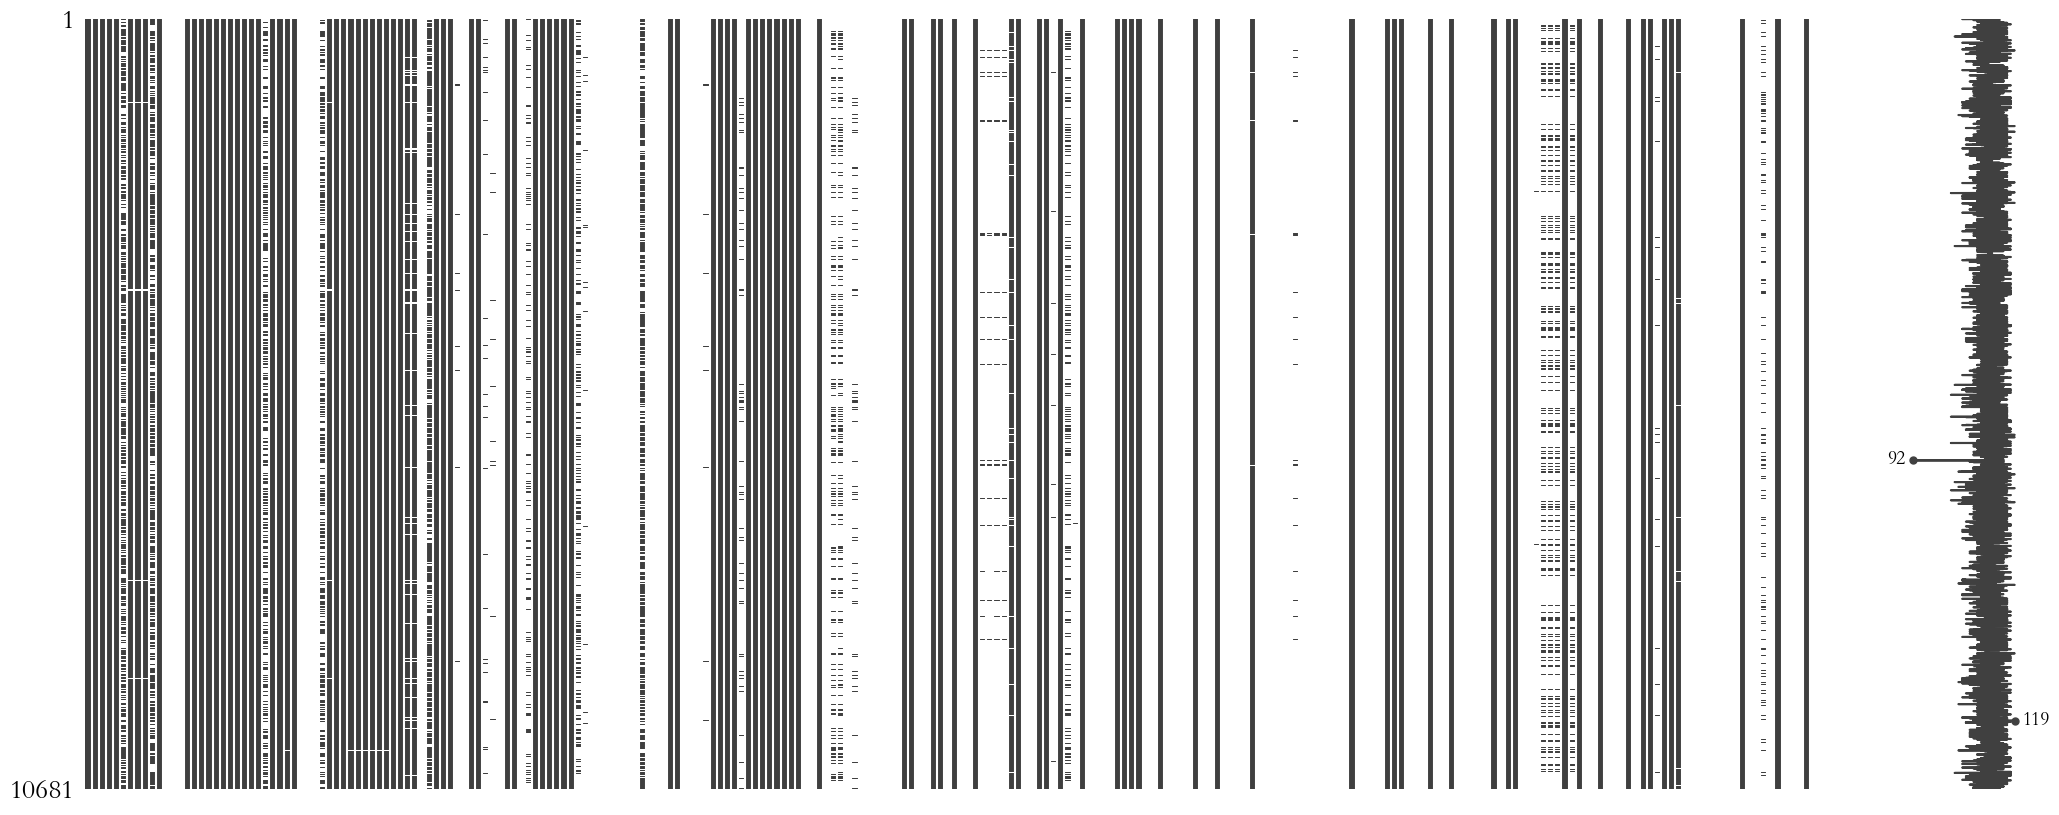

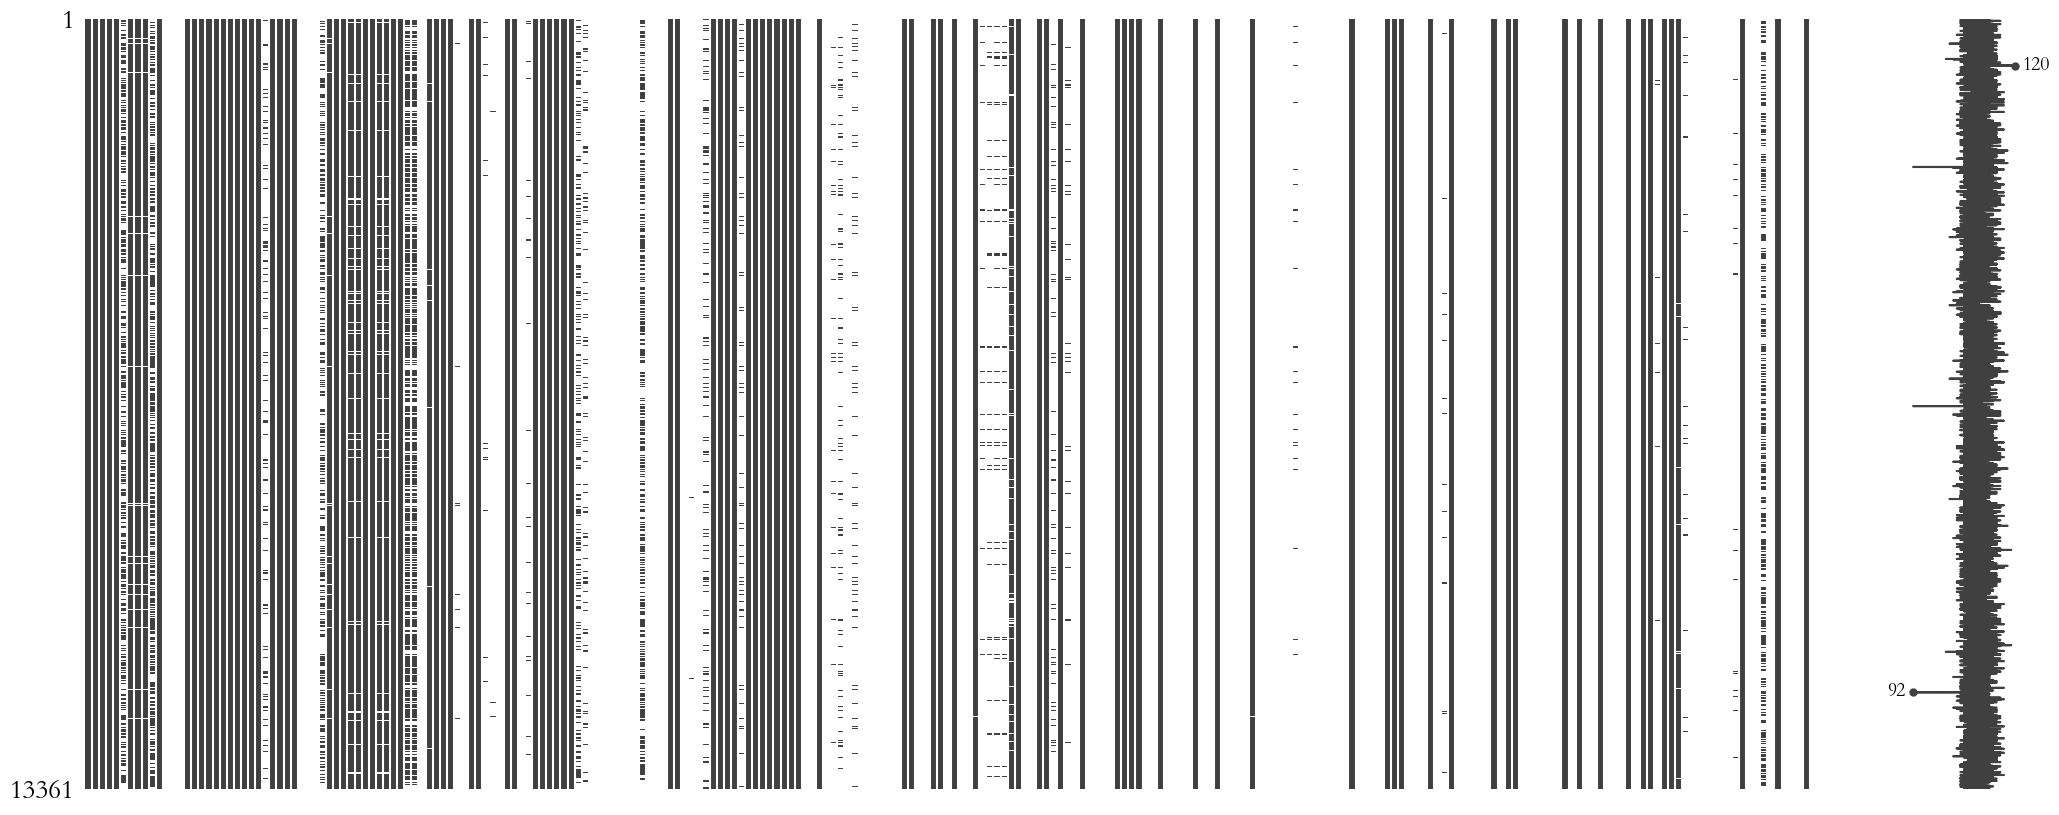

In [90]:
import missingno

missingno.matrix(data_n)
missingno.matrix(data_s)

In [91]:
data_s.dropna(axis=1,thresh=data_s.shape[0] - 1000, inplace=True)
data_n.dropna(axis=1,thresh=data_n.shape[0] - 1000, inplace=True)

<Axes: >

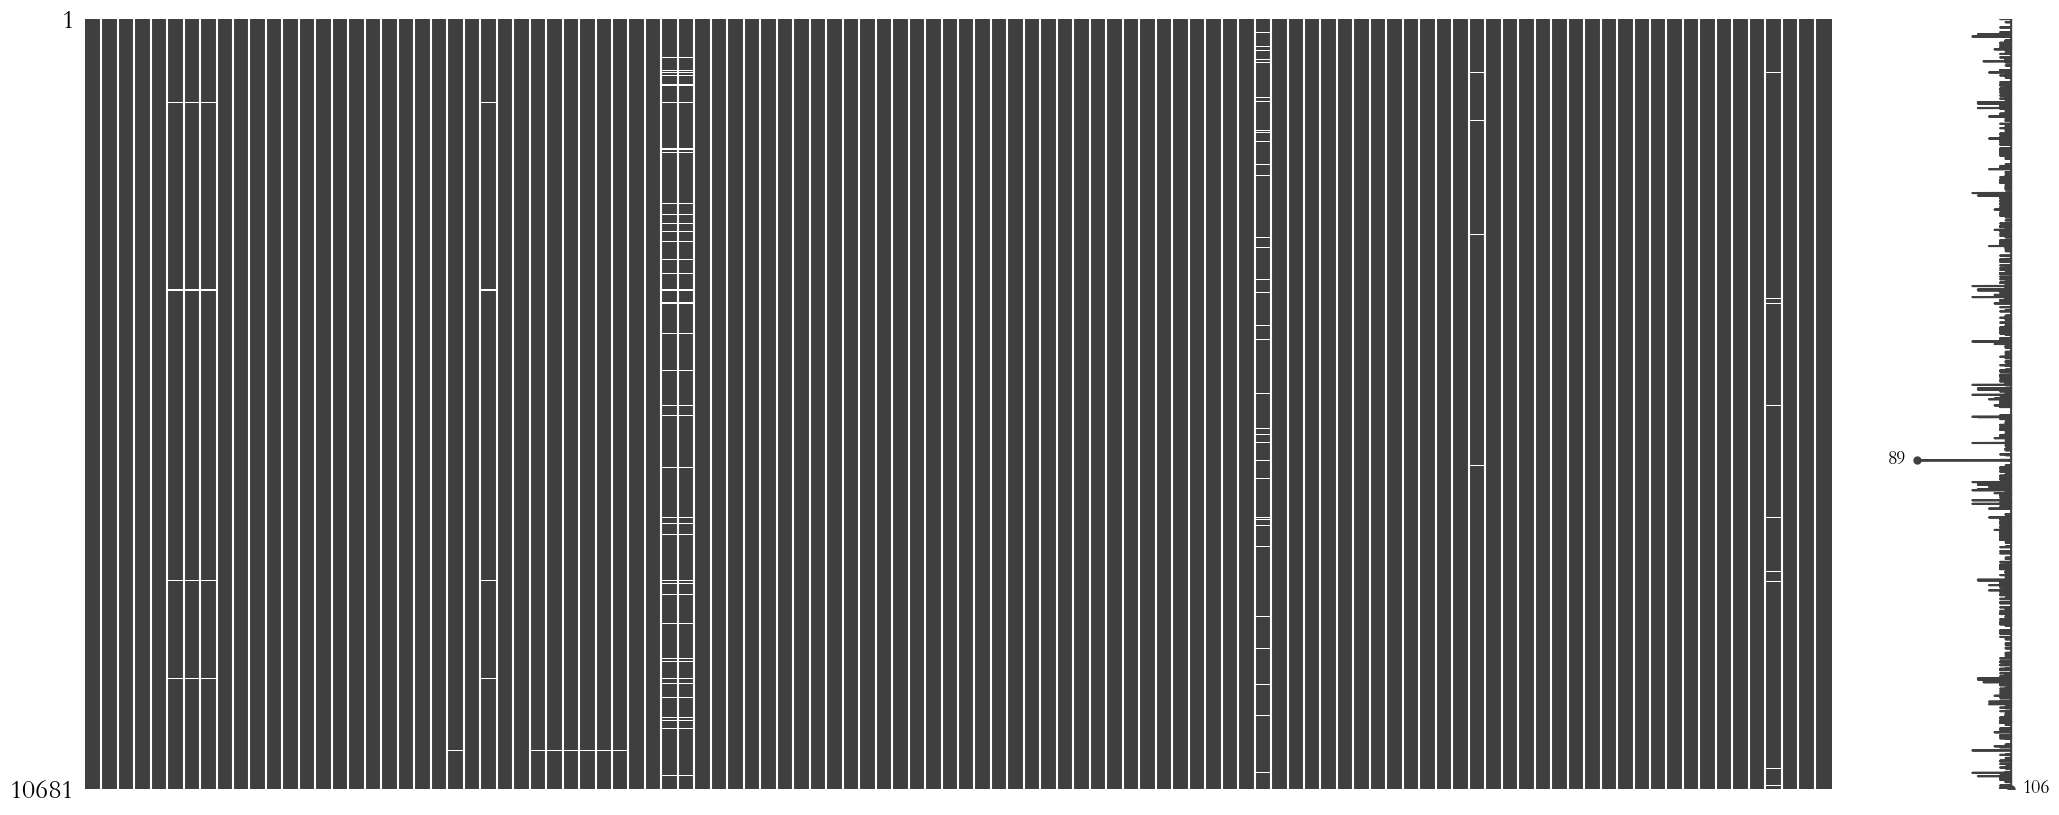

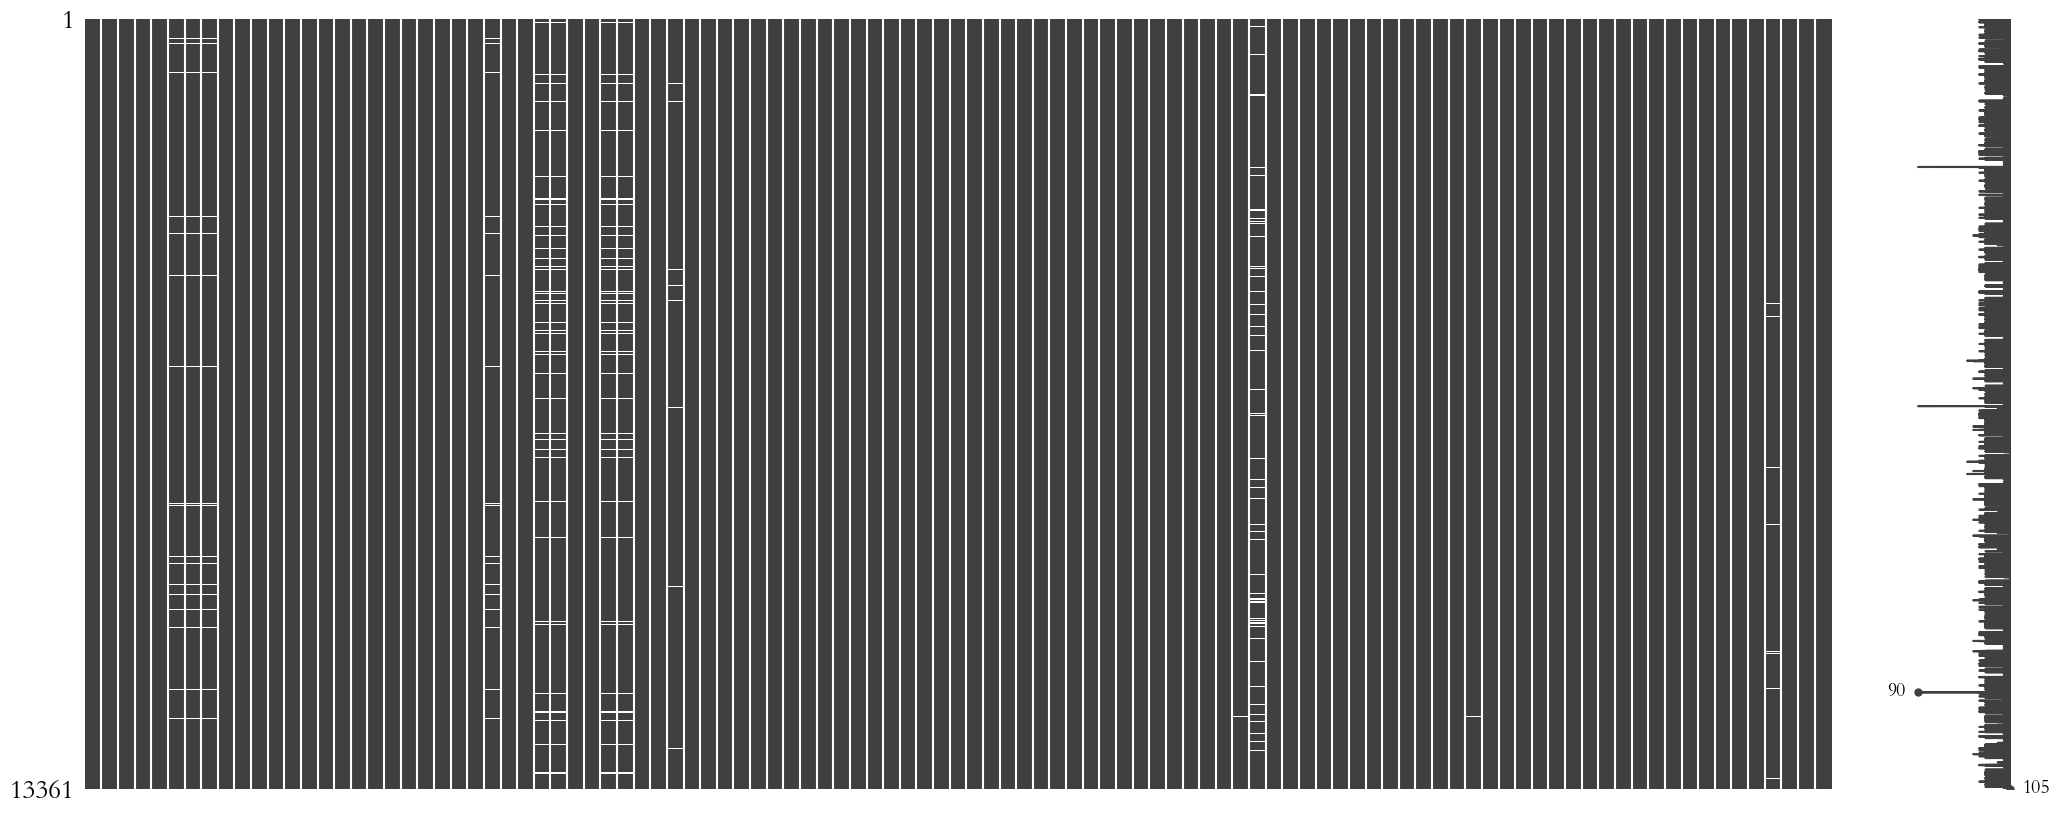

In [92]:
missingno.matrix(data_n)
missingno.matrix(data_s)

In [93]:
print(f'湖南数据大小: {data_s.shape}')
print(f'湖北数据大小: {data_n.shape}')

湖南数据大小: (13361, 105)

湖北数据大小: (10681, 106)

In [94]:
# import sweetviz as sv
# report = sv.analyze(data_s)
# report.show_html('湖南.html')

In [95]:
columns = ['发货流水号','送货客户','地址流水号','应收客户','开票客户','送货人','商务签收人名','物流签收人名',
'财务签收时间','财务签收人','放货人','销售业务员','原始单据扫描信息','创建人NO','创建人名称','提交人NO',
 '提交人名称','核算部门节点NO','成本中心','币种','是否是费用发货'
]
columns2 =['发货流水号','送货客户','地址流水号','应收客户','开票客户','送货人','商务签收人名','物流签收人名',
'财务签收时间','财务签收人','放货人','销售业务员','原始单据扫描信息','创建人NO','创建人名称','提交人NO',
 '提交人名称','核算部门节点NO','成本中心','币种','打印人', '打印时间'
]
data_s.drop(columns,axis=1,inplace=True)

In [96]:
data_n.drop(columns2,axis=1,inplace=True)
print(f'湖南数据大小: {data_s.shape}')
print(f'湖北数据大小: {data_n.shape}')

湖南数据大小: (13361, 84)

湖北数据大小: (10681, 84)

### 拆分数据

In [97]:
data_s['provience'] = '湖南'
data_n['provience'] = '湖北'

In [98]:
data = pd.concat([data_s,data_n[data_s.columns]],axis=0)

1. 对于连续型数据,采用均值填充
2. 对于离散型数据,采用向前插补进行填充
3. 对于日期型数据: ?有缺失的吗?

In [99]:
data_num = data.select_dtypes(['int','float'])
data_cat = data.select_dtypes(['object'])
data_time = data.select_dtypes(['datetime'])

In [100]:
print(f'数值型据大小: {data_num.shape}')
print(f'分类型数据大小: {data_cat.shape}')
print(f'时序型数据大小: {data_time.shape}')

数值型据大小: (24042, 30)

分类型数据大小: (24042, 48)

时序型数据大小: (24042, 7)

### 缺失值处理

<Axes: >

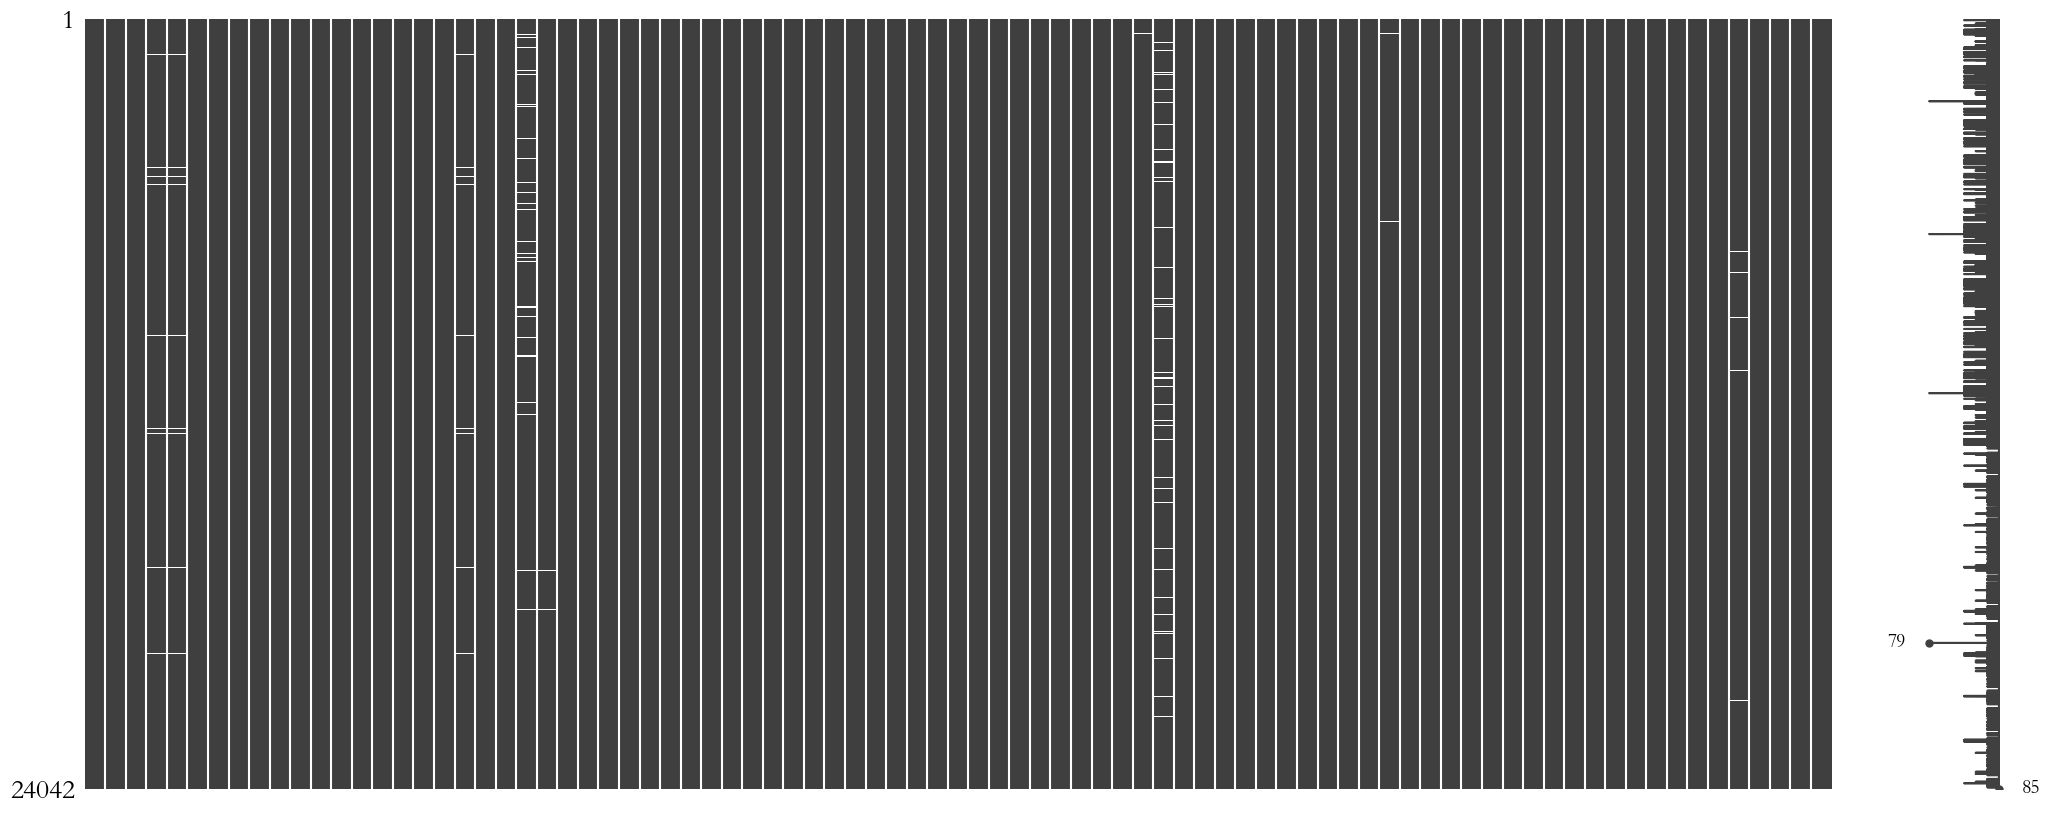

In [101]:
missingno.matrix(data)

In [102]:
data_cat = data_cat.groupby('provience').transform(lambda x:x.ffill())

In [105]:
data_cat['provience'] = data['provience']

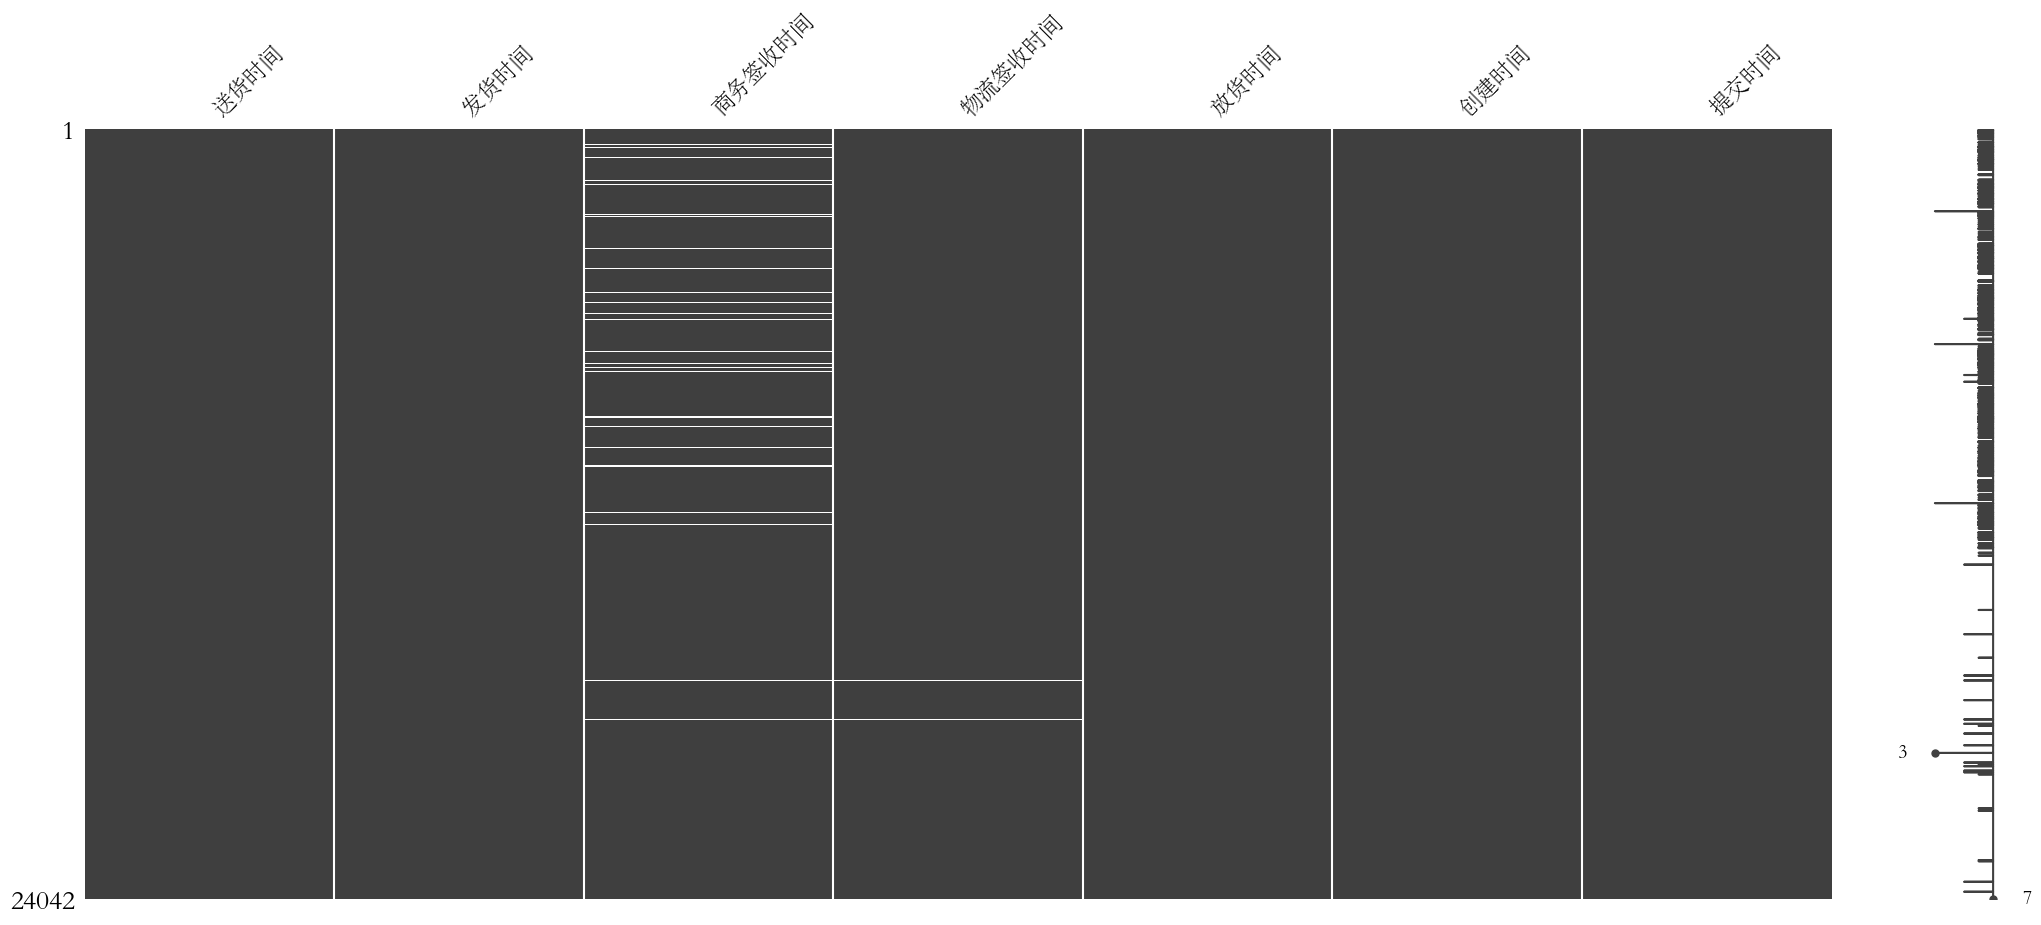

In [106]:
plt.rcParams['font.sans-serif'] = 'STsong'
missingno.matrix(data_time)
data_time[['商务签收时间','物流签收时间']] = data_time[['商务签收时间','物流签收时间']].ffill(axis=1)
data_time.drop('商务签收时间',axis=1,inplace=True)

In [107]:
data = pd.concat([data_num,data_cat,data_time],axis=1)

In [108]:
data = data.set_index('发货时间').loc['2020-01'].reset_index()

In [109]:
data.to_excel('./data/湖南_湖北.xlsx',index=None)

<p style='color:red'> 任务: 利用上述数据,完成湖南湖北两地,物流订单数量随时间变化的地图</p>

In [110]:
import numpy as np
import os
# json地图数据的构建
target_data = """{
        "type": "FeatureCollection",
        "features": []}"""
target_data = json.loads(target_data)
# 将云川渝的数据节点传入target_data，并加入area节点
list_region = os.listdir('./data/maps/')
name_list = []
for lr in list_region:
    with open(f"./data/maps/{lr}", 'r', encoding='utf-8') as f:
        temp = json.load(f)
        temp = temp['features']
        for tp in temp:
            name = tp['properties']['name']
            # 将area加入tp节点并传入target_data
            tp['properties']['area'] = '湖北湖南'
            target_data['features'].append(tp)
            name_list.append((name, np.random.randint(100, 5000)))

In [159]:
from pyecharts.charts import Map
maps = Map(init_opts=opts.InitOpts(theme='light',
                                      width='1000px',
                                      height='600px'))
maps.add_js_funcs(f"echarts.registerMap('湖北湖南', {target_data});")
# 引用添加的地图
maps.add("河师大",[('湖北省',100)],maptype='湖北湖南')
# maps.render()
# maps.render_notebook()

In [166]:
data['day'] = data['发货时间'].dt.day
dp = data.groupby(['provience','day']).size().reset_index()


In [164]:
data_pair = {}
for i in range(1,32):
    data_pair[f"第{i}天"] = dp[dp['day']==i][['provience',0]].values.tolist()

In [165]:
from pyecharts.charts import Timeline
t1 = Timeline()
for i in range(1,32):
    maps = Map(init_opts=opts.InitOpts(theme='light',
                                      width='1000px',
                                      height='600px'))
    maps.add_js_funcs(f"echarts.registerMap('湖北湖南', {target_data});")
    # 引用添加的地图
    maps.add("订单数量",data_pair[f'第{i}天'],maptype='湖北湖南')
    maps.set_global_opts(visualmap_opts=opts.VisualMapOpts(max_=800,min_=1))
    t1.add(maps,f'第{i}天')
t1.add_schema(play_interval=300)
t1.render_notebook()